In [18]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import minimize

<h4>Parameters<h4>

In [19]:
segment_count_beam = 100
vertical_level_count = 40
length_beam = 1000 # mm
horizontal_force = 7.4121 # N, + compression, - tension
youngs_modulus = 2e3 # MPa
moment_of_inertia = 20 # mm^4
channel_width_half = 10 # mm
boundary_penalty_coefficient = 1e5
pinned_penalty_coefficient = 1e5

In [20]:
3.14**2 * youngs_modulus * moment_of_inertia / length_beam**2

0.394384

<h4>Initial Guess<h4>

In [21]:
# ensure y=0 is possible
if vertical_level_count % 2 == 0:
    previous_vertical_level_count = vertical_level_count
    vertical_level_count +=1

# ensure ds>dy_max
if segment_count_beam > length_beam/(2*channel_width_half):
    previous_segment_count_beam = segment_count_beam
    segment_count_beam = int(length_beam/(2*channel_width_half))

y_levels = np.linspace(-channel_width_half, channel_width_half, vertical_level_count)
s, ds = np.linspace(0, length_beam, segment_count_beam+1, retstep=True)

In [22]:
def g(I_val, J_val, K_val):
    theta1 = np.arcsin((J_val - I_val) / ds)
    theta2 = np.arcsin((K_val - J_val) / ds)

    internal_strain_energy = 0.5 * youngs_modulus * moment_of_inertia * ( (theta2 - theta1)/ds )**2 * ds
    external_force_work = horizontal_force * np.cos(theta1) * ds
    
    return internal_strain_energy + external_force_work

In [23]:
C = {}
survivor = {}
index_zero = vertical_level_count//2

for I, J in product(range(vertical_level_count), repeat=2):
    if I == index_zero:
        C[(I, J, 1)] = 0
        survivor[(I, J, 1)] = None
    else:
        C[(I, J, 1)] = np.inf
        survivor[(I, J, 1)] = None

for m in range(2, segment_count_beam + 1):
    for J, K in product(range(vertical_level_count), repeat=2):
        best_cost = np.inf
        best_prev_I = None

        for I in range(vertical_level_count):
            prev_state_key = (I, J, m - 1)
            prev_cost = C.get(prev_state_key, np.inf)

            if prev_cost == np.inf:
                continue

            trans_cost = g(y_levels[I], y_levels[J], y_levels[K])
            total_cost = prev_cost + trans_cost

            if total_cost < best_cost:
                best_cost = total_cost
                best_prev_I = I

        C[(J, K, m)] = best_cost
        survivor[(J, K, m)] = best_prev_I

min_cost = np.inf
best_final_key = None

for J, K in product(range(vertical_level_count), repeat=2):
    current_key = (J, K, segment_count_beam)
    cost = C.get(current_key, np.inf)
    if cost < min_cost and K == index_zero:
        min_cost = cost
        best_final_key = current_key

if best_final_key is None or min_cost == np.inf:
    print("No valid path found (possibly all paths lead to infinite cost).")
else:
    path_indices = []
    current_J, current_K, current_m = best_final_key

    path_indices.append(current_K)
    path_indices.append(current_J)

    for m_step in range(segment_count_beam, 1, -1):
        prev_I = survivor[(current_J, current_K, m_step)]
        if prev_I is None:
            break
        path_indices.append(prev_I)
        current_K = current_J 
        current_J = prev_I


    final_J, final_K, _ = best_final_key
    reconstructed_y_indices = [final_K]
    reconstructed_y_indices.append(final_J)

    current_J_trace = final_J
    current_K_trace = final_K

    for m_trace in range(segment_count_beam, 1, -1):
        prev_I_trace = survivor[(current_J_trace, current_K_trace, m_trace)]
        if prev_I_trace is None:
            break
        reconstructed_y_indices.append(prev_I_trace)
        current_K_trace = current_J_trace
        current_J_trace = prev_I_trace

    reconstructed_y_indices.reverse()
    y_viterbi = [y_levels[i] for i in reconstructed_y_indices]

In [24]:
def x_from_y(y):
    dy = np.diff(y)
    dx = np.sqrt(ds**2 - dy**2)
    x = np.cumulative_sum(dx, include_initial=True)
    return x

In [25]:
x_viterbi = x_from_y(y_viterbi)
print(f"Δx = {x_viterbi[-1]-length_beam:.1f} mm")

# plt.figure()
# plt.plot(s, y_viterbi, marker="", linestyle="--", label = "y(s)")
# plt.plot(x_viterbi, y_viterbi, marker="", linestyle="--", label="y(x)")
# plt.axhline(channel_width_half)
# plt.axhline(-channel_width_half)
# plt.grid()
# plt.legend()
# plt.ylabel("y [mm]")
# plt.axis("equal")
# plt.show()

Δx = -2.3 mm


In [26]:
def energy_functional0(y):
    v = 0
    for i in range(len(y)-2):
        theta1 = np.arctan2(y[i+1] - y[i], ds)
        theta2 = np.arctan2(y[i+2] - y[i+1], ds)
        kappa = (theta2 - theta1) / ds
        internal_strain_energy = 0.5 * youngs_modulus * moment_of_inertia * kappa**2 * ds
        v += internal_strain_energy

    for i in range(len(y)-1):
        theta = np.arctan2(y[i+1] - y[i], ds)
        external_force_work = horizontal_force * np.cos(theta) * ds
        v += external_force_work

    penalty = (
        pinned_penalty_coefficient * (y[0]**2 + y[-1]**2)
        + boundary_penalty_coefficient * np.sum(np.maximum(y**2 - channel_width_half**2, 0))
    )

    return v + penalty


In [27]:
res0 = minimize( 
    energy_functional0, 
    x0=y_viterbi, 
    method="BFGS"
)

y_minimized0 = res0.x
x_minimized0 = x_from_y(y_minimized0)

In [28]:
def energy_functional1(y):
    v = 0
    for i in range(len(y)-2):
        theta1 = np.arcsin((y[i+1] - y[i]) / ds)
        theta2 = np.arcsin((y[i+2] - y[i+1]) / ds)
        kappa = (theta2 - theta1) / ds
        internal_strain_energy = 0.5 * youngs_modulus * moment_of_inertia * kappa**2 * ds
        v += internal_strain_energy

    for i in range(len(y)-1):
        theta1 = np.arcsin((y[i+1] - y[i]) / ds)
        external_force_work = horizontal_force * np.cos(theta1) * ds
        v+=external_force_work

    penalty = pinned_penalty_coefficient*(y[0]**2+y[-1]**2)
    
    return v + penalty

In [29]:
res1 = minimize( 
    energy_functional1, 
    x0=y_viterbi, 
    bounds = [
        (-channel_width_half, channel_width_half) for _ in range(segment_count_beam+1)
        ],
    method="L-BFGS-B",
    options={"maxfun": 100000}
)

y_minimized1 = res1.x
x_minimized1 = x_from_y(y_minimized1)

In [30]:
def energy_functional2(y):
    theta = np.arcsin(np.diff(y)/ds)
    diffs = np.diff(theta)
    v = 0.5 * youngs_modulus * moment_of_inertia * np.sum( (diffs/ds)**2 ) * ds + horizontal_force * np.sum(np.cos(theta)) * ds

    return v

In [31]:
res2 = minimize(
    energy_functional2,
    x0 = y_viterbi,
    method="SLSQP",
    constraints = [{"type": "eq", "fun": lambda y: y[-1]},
                {"type": "eq", "fun": lambda y: y[0]}],
    bounds = [(-channel_width_half, channel_width_half)
                for _ in range(segment_count_beam+1)],
)

y_minimized2 = res2.x
x_minimized2 = x_from_y(y_minimized2)

In [32]:
header = f'{"PARAMETER":<25}  {"VALUE":<10}  {"UNIT":<10}'

parameters_data = [
    ("Beam Segment Count", segment_count_beam, ""),
    ("Vertical Level Count", vertical_level_count, ""),
    ("Beam Length", length_beam, "mm"),
    ("Horizontal Force", horizontal_force, "N"),
    ("Young's Modulus", youngs_modulus, "MPa"),
    ("Moment of Inertia", moment_of_inertia, "mm^4"),
    ("Channel Half-Width", channel_width_half, "mm"),
    ("Boundary Penalty Coeff", f"{boundary_penalty_coefficient:.0e}", ""),
    ("Pinned Penalty Coeff", f"{pinned_penalty_coefficient:.0e}", ""),
    ("Beam End x-Displacement", f"{x_minimized2[-1]-length_beam:.1f}", "mm"),

]

body_lines = []
for name, value, unit in parameters_data:
    value_str = str(value)
    body_lines.append(f"{name:<25}  {value_str:<10}  {unit:<10}")

solver_params_string = "\n".join([
    header,
    *body_lines
])

In [33]:
header_methods = f'{"METHOD":<18}  {"SUCCESS":<10}  {"MESSAGE"}'

methods_data = [
    ("BFGS", res0.success, res0.message),
    ("L-BFGS-B", res1.success, res1.message),
    ("Vectorised SLSQP", res2.success, res2.message)
]

body_methods = []
for method, success, message in methods_data:
    success_str = str(success)
    body_methods.append(f"{method:<18}  {success_str:<10}  {message}")

methods_table = "\n".join([header_methods, *body_methods])

The beam segment count has been adjusted to 50 (was 100).
The vertical level count has been adjusted to 41 (was 40).
METHOD              SUCCESS     MESSAGE
BFGS                False       Desired error not necessarily achieved due to precision loss.
L-BFGS-B            True        CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Vectorised SLSQP    True        Optimization terminated successfully


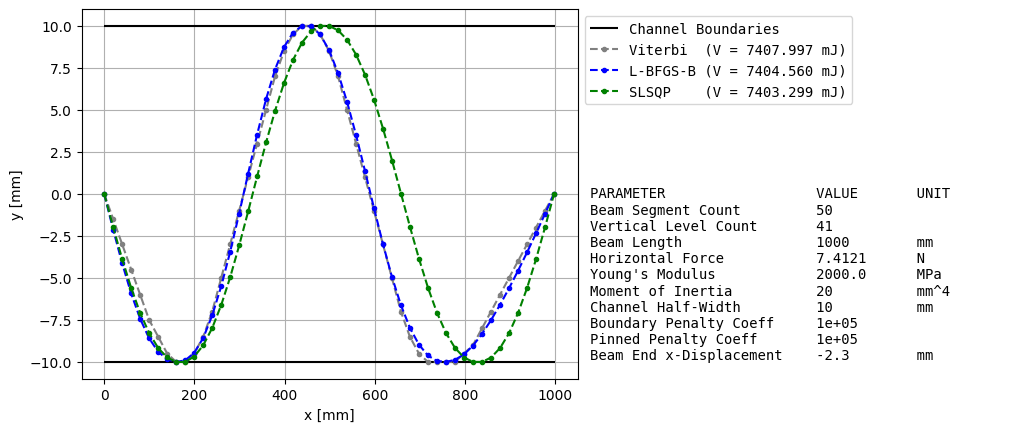

In [34]:
if previous_segment_count_beam != segment_count_beam:
    print(f"The beam segment count has been adjusted to {segment_count_beam} (was {previous_segment_count_beam}).")

if previous_vertical_level_count != vertical_level_count:
    print(f"The vertical level count has been adjusted to {vertical_level_count} (was {previous_vertical_level_count}).")

print(methods_table)

plt.hlines(channel_width_half, 0, length_beam, color="black", label="Channel Boundaries")
plt.hlines(-channel_width_half, 0, length_beam, color="black")


plt.plot(x_viterbi, y_viterbi, marker=".", linestyle="--", color="grey",
        label=f"Viterbi  (V = {energy_functional2(np.array(y_viterbi)):.3f} mJ)")
if res0.success == True:
    plt.plot(x_minimized0, y_minimized0, marker=".", linestyle="--", color="brown",
        label=f"BFGS     (V = {energy_functional2(y_minimized0):.3f} mJ)")
if res1.success == True:
    plt.plot(x_minimized1, y_minimized1, marker=".", linestyle="--", color="blue",
        label=f"L-BFGS-B (V = {energy_functional2(y_minimized1):.3f} mJ)")
if res2.success == True:
    plt.plot(x_minimized2, y_minimized2, marker=".", linestyle="--", color="green",
        label=f"SLSQP    (V = {energy_functional2(y_minimized2):.3f} mJ)")


plt.legend(loc="upper left", bbox_to_anchor=(1, 1), prop="monospace")
plt.figtext(0.92, 0.15, solver_params_string, fontfamily="monospace")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
# plt.axis("equal")
plt.grid()
plt.show()